In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal


sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [2]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [3]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

#  Implements the E-Step of GPFA

In [4]:
n_neurons = 200 #q
hiddenDim = 12 #p
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
T_max = len(t)

tav = np.random.randint(1,3,size=hiddenDim)
sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.array([5*np.arange(0,n_neurons),
              np.abs(45 - 5*np.arange(0,n_neurons,))])#
C = np.random.randint(-20,20,size=(n_neurons,hiddenDim))/2
d = np.random.randint(40,50,size=(n_neurons))



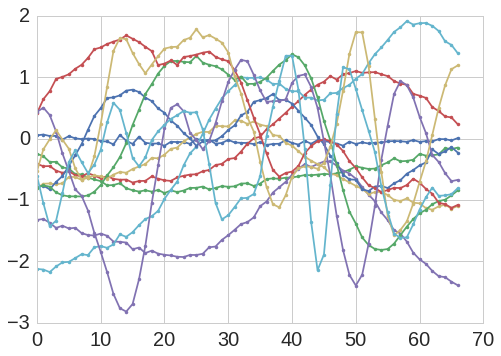

In [5]:
x = np.zeros([hiddenDim,T_max])

length_scales_GP = [10**(1 if i== 0 else .5-i*.1) for i in range(hiddenDim)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[0]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()#*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(T_max-35),np.cos(np.linspace(0,.5*np.pi,num=5)),np.zeros(10)])

for i in range(hiddenDim):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
y = C.dot(x) + d[:,None] + np.random.normal(loc=0,scale=5,size=(n_neurons,T_max))

In [6]:
data = {}
ground_truth = {'C':C,
                'd':d,
                'l':length_scales_GP,
                'x':x}

In [7]:
#Here are the random hidden states data is being drawn from
X_bar = np.array([x.T.flatten()])


In [8]:
params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [9]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [10]:
params['C'].shape

(200, 12)

In [11]:
def make_Kbig(params,t,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


In [12]:
K_big,_ = make_Kbig(params,t)
C_big = make_Cbig(C,t)

In [13]:
st = time.time()
n = K_big.dot(C_big.T).dot(np.linalg.inv(C_big.dot(K_big).dot(C_big.T) + 1e-3*np.eye(T_max*n_neurons))).dot(y.T.flatten(order='C') - np.tile(d,T_max))
print time.time() - st

73.7762770653


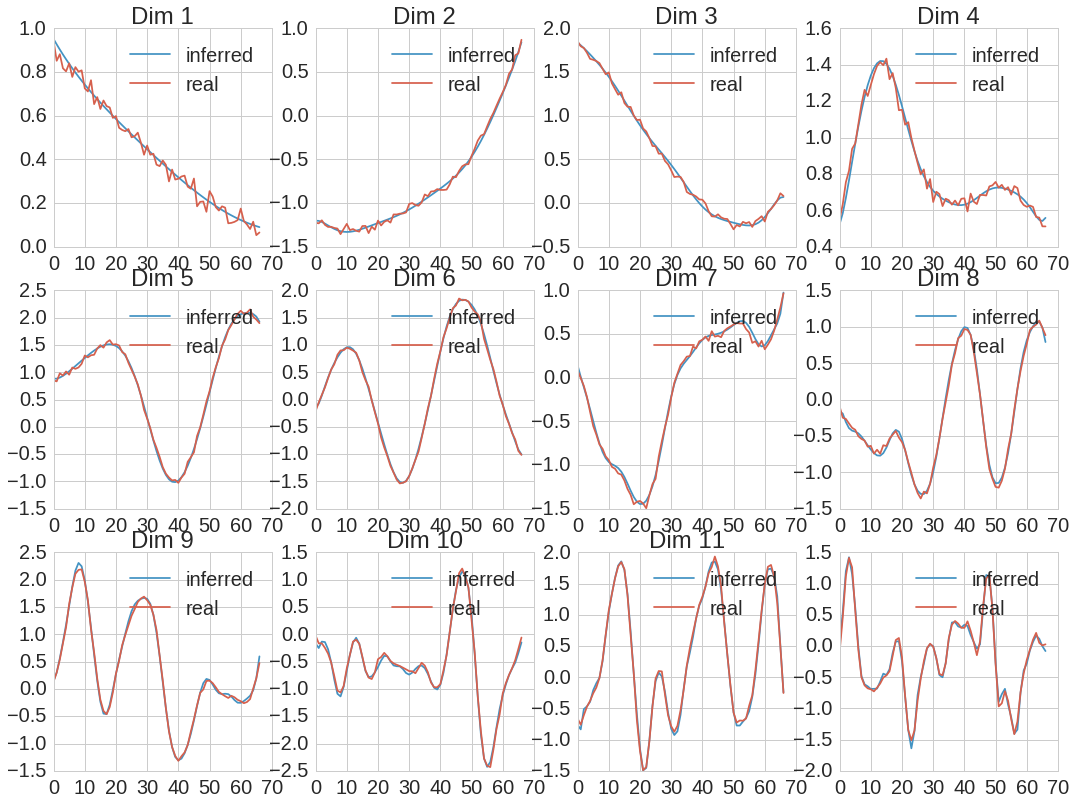

In [14]:
newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(18,18))
clrs = seaborn.color_palette('RdBu',n_colors=4)

nRows, nCols= [np.ceil(np.sqrt(hiddenDim)).astype('int')]*2
for i in range(hiddenDim):
    plt.title('Dim %s' %i)
    plt.subplot(nRows,nCols,i+1)
    plt.plot(newN[i],color=clrs[-1],label='inferred')
    plt.plot(x[i],color=clrs[0],label='real')

    plt.legend()

#  Ok now lets generate Poisson Data

In [13]:
np.exp(3)

20.085536923187668

In [14]:
n_neurons = 60 #q
nDims = 3#
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.random.normal(loc=0,scale=.5,size=(n_neurons,nDims))/2
d = np.random.randint(0,6,size=(n_neurons))/2



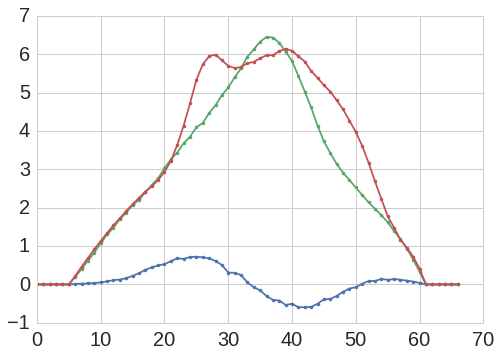

In [15]:
x = np.zeros([nDims,nT])

length_scales_GP = [10**(.1 if i== 0 else -i*.2) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,9)-3]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=25)),np.ones(nT-55),np.cos(np.linspace(0,.5*np.pi,num=20)),np.zeros(5)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
#y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))
y = np.random.poisson(rate_params)

In [16]:
params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [17]:
x.shape

(3, 67)

In [18]:
K_big,_ = make_Kbig(params,t)  #this is the prior covariance of the GP latent state
C_big = make_Cbig(C,t)

In [19]:
xbar = np.array([x.T.flatten()]).T
ybar = np.array([y.T.flatten()])

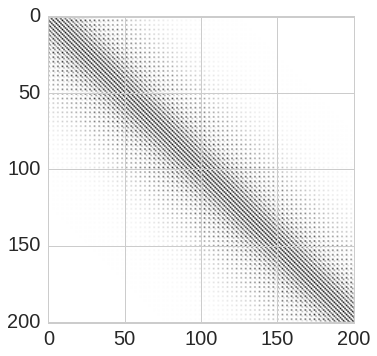

In [20]:
plt.imshow(K_big)

In [21]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    
    
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  .5*xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [22]:
nDims = C.shape[1]
nT = len(t)

In [24]:
xInit = np.zeros(nDims*nT)

In [36]:
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)

In [37]:
####

import pGPFA
import scipy.optimize as op
import scipy as sp
resLap = op.minimize(
    fun = pGPFA._lapinf.lap_post_unNorm,
    x0 = xInit,
    method='Newton-CG',
    args = (ybar, C_big, d, K_bigInv,t,n_neurons),
    jac = pGPFA._lapinf.lap_post_grad,
    hess = pGPFA._lapinf.lap_post_hess,
    options = {'disp': False,'maxiter': 10000,'xtol':1e-32
})

In [31]:
####
import scipy.optimize as op
resLap = op.minimize(
    fun = calc_post_unNorm,
    x0 = xInit,
    method='Newton-CG',
    args = (ybar, C_big, d, K_bigInv,t,n_neurons),
    jac = calc_post_grad,
    hess = calc_post_hess,
    options = {'disp': False,'maxiter': 10000,'xtol':1e-32
})

In [38]:
x_post_mean = resLap.x.reshape(nDims,nT,order='F')

hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
PostCovGP = np.linalg.inv(hess)

PostCovGP = PostCovGP 
SD2 = 2*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

In [39]:
x_post_mean.shape

(3, 67)

In [40]:
seaborn.color_palette('deep',n_colors=nDims+1,desat=1)

[(0.29803921568627456, 0.44705882352941156, 0.6901960784313725),
 (0.33333333333333337, 0.6588235294117647, 0.40784313725490207),
 (0.7686274509803922, 0.3058823529411766, 0.32156862745098036),
 (0.5058823529411764, 0.44705882352941173, 0.6980392156862745)]

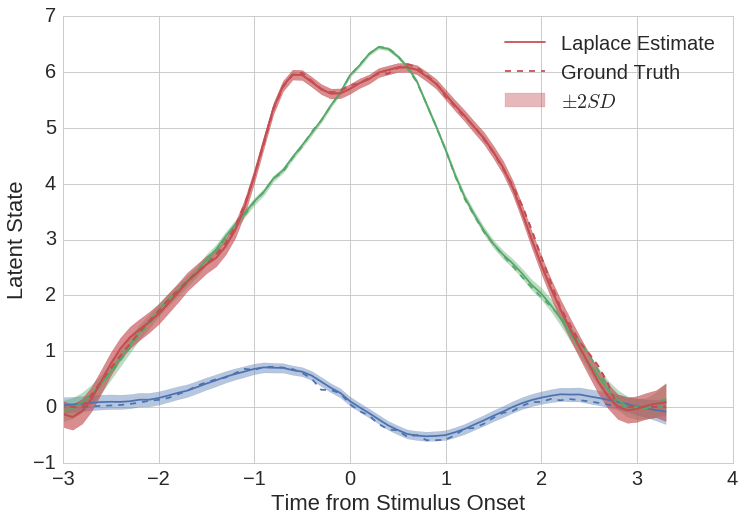

In [41]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(x_post_mean,x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

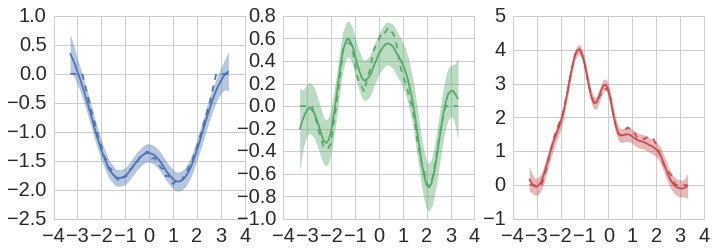

In [700]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(x_post_mean,x):
    plt.subplot(2,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
#plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
#plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
#plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

#plt.ylabel('Latent State')
#plt.xlabel('Time from Stimulus Onset')
#plt.xlim(-3,)
#plt.legend(loc='best')

## Plot Some Real and Smoothing out spike Rates

In [42]:
newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(32,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= 12,12

tt = 0
for real,sim in zip(rate_params,np.exp(C.dot(x_post_mean).T+d).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(real,color=clrs[0],linewidth=3,alpha=0.6)
        plt.plot(sim,color=clrs[-1],linewidth=3)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.legend()
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


NameError: name 'n' is not defined

# Now check gradients

In [665]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    
    
    nT = len(t)
    xbar = np.array([xbar]).T
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    Aexp = np.float128(np.exp(A))
    L1 = np.dot(np.ones(n_neurons*nT),Aexp)
    L2 =  ybar.dot(A)
    L3 =  .5*xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    xbar = np.array([xbar]).T
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    #A = np.float128(A
    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3
    #print dL1[0], dL2[0], dL3[0]

    return np.squeeze(dL)

In [684]:
x2 =np.random.normal(size=x.shape)

In [685]:
xbar2 = x2.T.flatten()

In [690]:
r2 = op.approx_fprime(np.squeeze(xbar2),
                calc_post_unNorm,
                1e-6,
                ybar,C_big,d,K_bigInv,t,n_neurons)

In [691]:
np.allclose(xbar2,np.array([np.squeeze(xbar2)]).T)

False

In [692]:
r1 = calc_post_grad(np.squeeze(xbar2),ybar,C_big,d,K_bigInv,t,n_neurons)

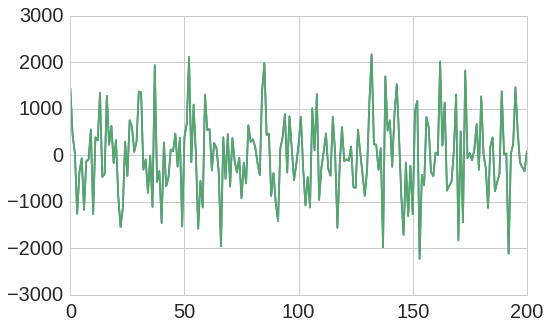

In [693]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(r1)
plt.plot(r2)


In [637]:
np.sum(r1-r2)

571.49358786565812274

In [638]:
np.corrcoef(r1,r2)

array([[ 1.0,  0.015464303],
       [ 0.015464303,  1.0]], dtype=float128)

In [554]:
from numpy.linalg import norm

In [555]:
norm(r1-r2)/norm(r1+r2)

2.2688767779878573623e-07

In [556]:
norm(r1-r2)/norm(r1+r2)

2.2688767779878573623e-07

In [548]:
print np.max(r1)/np.max(r2)

1.00000123526


# Check Hessian

In [627]:
from statsmodels.tools.numdiff import approx_hess1, approx_hess2

In [628]:
xbar2 =np.random.normal(size=xbar.shape)

In [630]:
calculate_cost_function = calc_post_unNorm

In [631]:
h = approx_hess2(np.squeeze(xbar2),calc_post_unNorm,1e-2,(ybar,C_big,d,K_bigInv,t,n_neurons))

In [632]:
h2 = calc_post_hess(xbar2,ybar,C_big,d,K_bigInv,t,n_neurons)

In [633]:
h - h2

array([[  2.21238317e-04,   3.25384515e-05,   1.33180108e-05, ...,
          1.69091705e-07,   1.45519152e-07,   2.54658516e-07],
       [  3.25384515e-05,   1.03606710e-04,   1.02705581e-05, ...,
          7.27595761e-08,   1.45137236e-07,   3.27418093e-07],
       [  1.33180108e-05,   1.02705581e-05,   2.32177948e-04, ...,
          2.54658516e-07,   1.45519152e-07,   4.45054288e-07],
       ..., 
       [  1.69091427e-07,   7.27595761e-08,   2.54658516e-07, ...,
          1.87838190e-04,   2.95440077e-05,   1.27974507e-05],
       [  1.45519152e-07,   1.45137251e-07,   1.45519152e-07, ...,
          2.95440077e-05,   1.12663741e-04,   1.69977579e-05],
       [  2.54658516e-07,   3.27418093e-07,   4.45054289e-07, ...,
          1.27974507e-05,   1.69977579e-05,   2.30611591e-04]])

In [634]:
norm(h-h2)/norm(h+h2)

1.2948518023222201e-07